In [4]:
#Credit: https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from sklearn.cross_validation import train_test_split
from collections import defaultdict
from pattern.en import parse
from pattern.en import pprint
from pattern.en import singularize
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text 
import re
#import findspark
#findspark.init()
#import pyspark
#from pyspark.sql import SQLContext
import re
DATAFILEPATH='/Users/Dilip_MBP/Documents/CS109/PROJECT/project_cs109/data/'
#DATAFILEPATH='C:/Users/balachandrd/Documents/Personal/CS-109/Project/project_cs109/data/'



In [5]:
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")
stopwords=text.ENGLISH_STOP_WORDS
CUSTOM_STOPWORDS=['bike', 'bicycle']


In [6]:
# Read and store csv data in to Master index

bike_masterdf = pd.read_csv(DATAFILEPATH+'bike_details.csv')
print "Number of samples in the database:", bike_masterdf.shape[0]
bike_masterdf.head(2)

Number of samples in the database: 59619


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch
0,0,50088,Schwinn Gateway,absent,Schwinn,Gateway,NaN,NaN,NaN,False,False,NaN,1970-01-01 00:00:00,2015-07-06 22:27:01,2015-11-03 05:36:54,https://bikeindex.org/bikes/50088,https://bikeindex.org/api/v1/bikes/50088,117,NaN,NaN,NaN,NaN,True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1436221621,1446529014,0
1,1,60140,2016 Specialized Diverge Elite DSW,WSBC601010269K,Specialized,Diverge Elite DSW,2016,NaN,NaN,False,False,NaN,1970-01-01 00:00:00,2015-10-08 19:18:50,2015-11-03 05:34:30,https://bikeindex.org/bikes/60140,https://bikeindex.org/api/v1/bikes/60140,307,NaN,NaN,52cm,NaN,True,NaN,Bike,False,NaN,NaN,NaN,aluminum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1444331930,1446528870,0


In [7]:
# Remove nulls in theft description - only stolen bikes have theft description -> store in filtered dataframe
num_stolen = len(bike_masterdf.stolen[bike_masterdf.stolen == True])
print "Number of bikes reported as stolen: ", num_stolen
print "Proportion of bikes reported as stolen:  %.2f" % (float(num_stolen)/float(bike_masterdf.shape[0]))
desc_mask = bike_masterdf.theft_description.isnull()
bike_subdf = bike_masterdf[~desc_mask]
print "Number of Stolen bikes with theft description:", bike_subdf.shape[0]

#bike_subdf.to_json('./stolen_bikes.json')
bike_subdf.head(2)

Number of bikes reported as stolen:  33182
Proportion of bikes reported as stolen:  0.56
Number of Stolen bikes with theft description: 29838


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch
3,3,11542,2013 Trek 4300,WTU124C5170G,Trek,4300,2013,NaN,NaN,False,True,"San Jose, CA, 95126",2013-06-10 06:00:00,2013-08-20 06:00:00,2015-11-03 05:11:14,https://bikeindex.org/bikes/11542,https://bikeindex.org/api/v1/bikes/11542,47,NaN,NaN,NaN,"Trek 4300, Mountain bicycle, disc brakes, blac...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7889,1370844000,"San Jose, CA, 95126",37.329012,-121.916021,bike rack,NaN,NaN,T13006853,San Jose,2014-06-14 17:52:49,False,"1323 Martin Ave, San Jose, CA 95126, USA",1323,Martin Avenue,95126,Shasta-Hanchett Park,San Jose,Santa Clara County,California,United States,1370844000,1376978400,1446527474,1402768369
4,4,13359,2010 Schwinn Katana,absent,Schwinn,Katana,2010,https://files.bikeindex.org/uploads/Pu/4903/sm...,https://files.bikeindex.org/uploads/Pu/4903/la...,False,True,"Sandusky, OH, 44870",2010-07-10 06:00:00,2010-07-11 06:00:00,2015-11-03 05:17:53,https://bikeindex.org/bikes/13359,https://bikeindex.org/api/v1/bikes/13359,117,NaN,NaN,58cm,"The bike is a grey, blue, and black Schwinn Ka...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,9705,1278741600,"Sandusky, OH, 44870",41.440356,-82.768114,car bike rack Reward: $75,NaN,NaN,2010004433,Sandusky,2014-06-14 18:17:08,False,"4614 Venice Heights Blvd, Sandusky, OH 44870, USA",4614,Venice Heights Boulevard,44870,NaN,Sandusky,Erie County,Ohio,United States,1278741600,1278828000,1446527873,1402769828


In [8]:
theft_desc_word_count = bike_subdf.theft_description.apply(lambda x: len(x.split()))
#theft_desc_word_count = np.array(theft_desc_list.apply(lambda x: len(x.split())))


Theft description with maximum word count: 558
Theft description with minimum word cunt:  0
Average word count of description: 10.21
<class 'pandas.core.series.Series'>


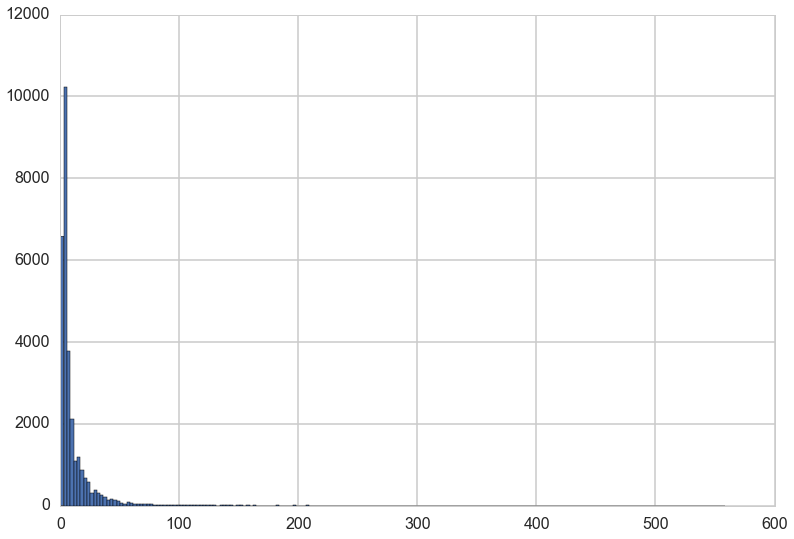

In [21]:
theft_desc_word_count.hist(bins=200)
print "Theft description with maximum word count:", max(theft_desc_word_count)
print "Theft description with minimum word cunt: ", min(theft_desc_word_count)
print "Average word count of description: %.2f" % np.mean(theft_desc_word_count)
print type(theft_desc_word_count)

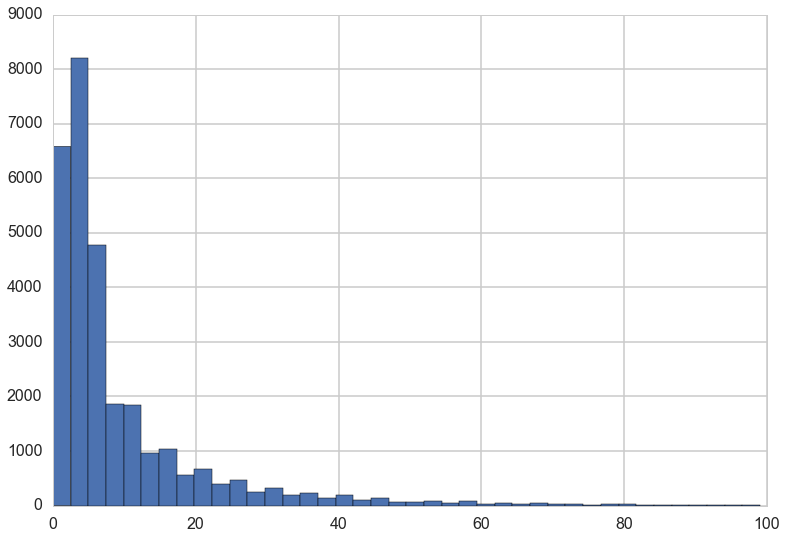

In [10]:
theft_desc_word_count_small = theft_desc_word_count[theft_desc_word_count < 100]
theft_desc_word_count_large = theft_desc_word_count[theft_desc_word_count > 100]
theft_desc_word_count_small.hist(bins=40)



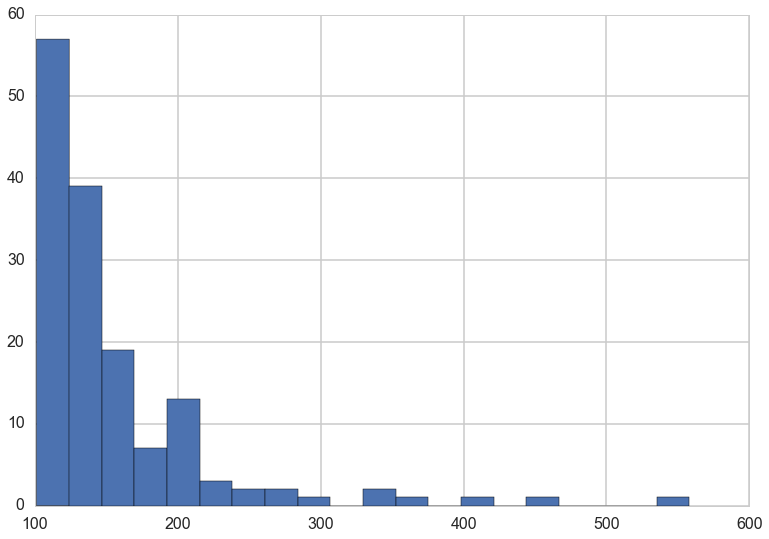

In [11]:
theft_desc_word_count_large.hist(bins=20)

In [12]:
#TEMP:
print (bike_subdf.theft_description[0:10])

3                                             bike rack
4                             car bike rack Reward: $75
5                      Backyard Reward: I have no money
6                              Open Garage Reward: $300
7     15\\" thick steel hand railing to which my bik...
8                              Powell Park Reward: $100
9                 PCC SE Campus at SE 82nd and Division
10                                         Reward: $150
11    A bike rack. Reward: A BIG HUG, MAYBE MONEY TO...
13                                                     
Name: theft_description, dtype: object


In [13]:
#Process each document (theft description belonging to each sample) by removing stop words, punctuations etc.
# Trail run on training data
#setting min_df =1
vectorizer = CountVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(bike_subdf.theft_description)    #************* May need to use mask for train/test 
#X = X.tocsc() 
id2words = dict((v, k) for k, v in vectorizer.vocabulary_.iteritems())
corpus_gensim = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

In [14]:
corpus_gensim.sparse.shape

(5708, 29838)

In [15]:
# 1st model using LDA  to understand semantics of classifier
lda = gensim.models.ldamodel.LdaModel(corpus_gensim, id2word=id2words, num_topics=2, update_every=1, chunksize=100, passes=1)

In [16]:
print lda.print_topics()

[u'0.242*reward + 0.070*rack + 0.067*100 + 0.058*bike + 0.052*garage + 0.048*50 + 0.034*00 + 0.026*200 + 0.024*home + 0.015*yes', u'0.066*bike + 0.034*stolen + 0.032*locked + 0.020*lock + 0.013*parking + 0.012*building + 0.012*cut + 0.012*apartment + 0.009*inside + 0.009*left']


In [22]:
print "The above was a direct LDA run on the data related to theft description. We can see that there is a lot of garbage that needs to be filtered out of the descriptions to make topic selection better"

print "We can use Penn Treebank II tag set to parse the worse and filter words that do not apply to our topic selection.\
The basic exercise here is to identify specific details pertaining to where the bikes were stole from. Mostly these will be captured \
by the nouns. Let us start by only looking for nouns"


The above was a direct LDA run on the data related to theft description. We can see that there is a lot of garbage that needs to be filtered out of the descriptions to make topic selection better
We can use Penn Treebank II tag set to parse the worse and filter words that do not apply to our topic selection.The basic exercise here is to identify specific details pertaining to where the bikes were stole from. Mostly these will be captured by the nouns. Let us start by only looking for nouns


In [23]:
# Create function to parse incoming text, tokenize and check for  ******* Nouns
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")


def gather_nouns(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)
    thetext = thetext.lower()
    nouns=[]
    for sentence in parse(thetext, tokenize=True, lemmata = True, encoding = 'utf-8').split():
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['NN', 'NNS']:
                    if token[4] in CUSTOM_STOPWORDS or token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns.append(token[4])
    nouns2=[]

    for n in nouns:
        if len(n)!=0:
            nouns2.append(n)
        else:
            print "************** WE HAVE A PROBLEM **************"
    return ' '.join(nouns2)

In [19]:
atext = "The bikes were locked to a sign pole in my apartment by the corner of the superstore. The lock was a combination lock and i had \
tied chained my helmet to the bike. We have fairly good security in the block of apartments here. The bike was of make 'GT' with shimano\
gears and had a custom seat. The apartment's security office told me that i have no chance of retrieving the bike"
print gather_nouns(atext)
print "\n"
#print parse(atext)


sign pole apartment corner superstore lock combination lock helmet security block apartment make gt shimanogear custom seat apartment security office chance




In [24]:
#Tokenize each theft description to return a list of nouns, proper nouns etc for each sample (row)
# We will remove words whose word count is less than 2
parsed_nouns = bike_subdf.theft_description.apply(gather_nouns)
vectorizer_nouns = CountVectorizer(min_df=2, stop_words='english')
X_nouns = vectorizer_nouns.fit_transform(parsed_nouns)    #************* May need to use mask for train/test 
id2words_nouns = dict((v, k) for k, v in vectorizer_nouns.vocabulary_.iteritems())
corpus_gensim_nouns = gensim.matutils.Sparse2Corpus(X_nouns, documents_columns=False)

In [25]:
# From vectorizer, gather word-frequency data to look for highy frequency words
#Credit: http://stackoverflow.com/questions/16078015/list-the-words-in-a-vocabulary-according-to-occurrence-in-a-text-corpus-scikit

Nouns = vectorizer_nouns.get_feature_names()
Noun_Counts = np.asarray(X_nouns.sum(axis=0)).ravel()
#word_freq_dict = {'Nouns': Nouns, 'Count':Noun_Counts}
#word_frequency = zip(vectorizer_nouns.get_feature_names(),np.asarray(X_nouns.sum(axis=0)).ravel())
word_frequency = pd.DataFrame({'Nouns': Nouns, 'Count':Noun_Counts})
sorted_w_freq_df = word_frequency.sort(columns='Count', ascending=False)
#sorted_w_freq_df.to_csv(DATAFILEPATH+'noun_frequency.csv')

/Users/Dilip_MBP/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


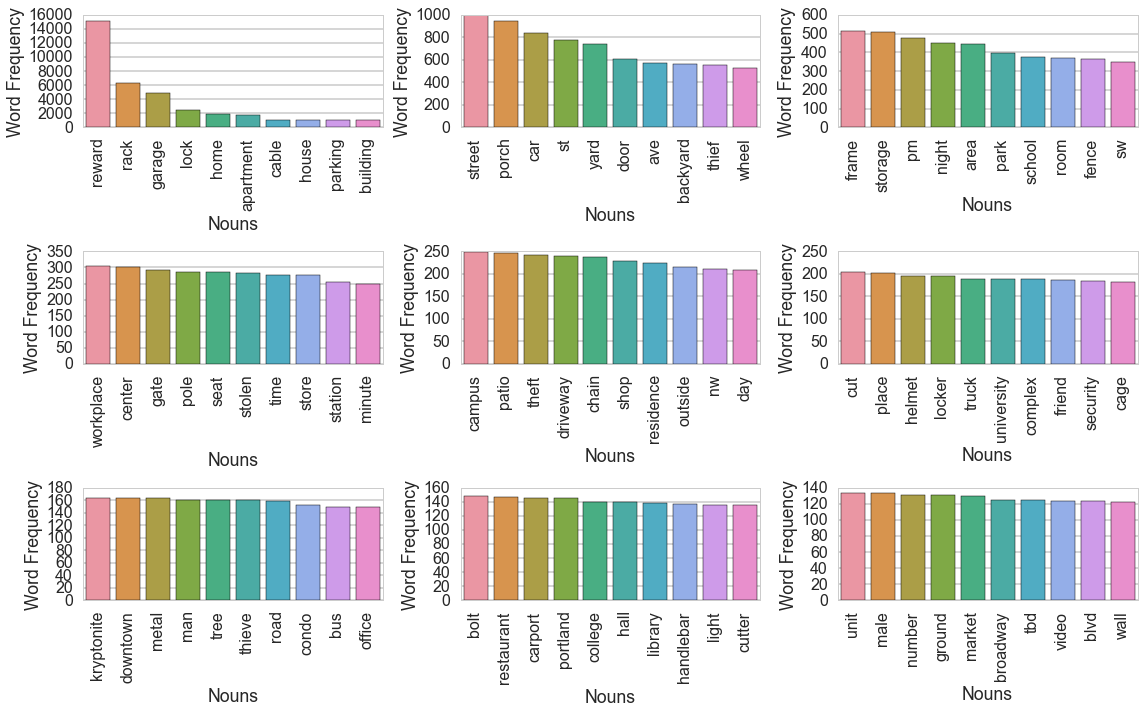

In [26]:
# Plot bar graph of Frequency of top 60 words 
#
nrows=3
ncols=3
plt_rows = np.arange(nrows)
plt_cols = np.arange(ncols)
f1, ax1 = plt.subplots(figsize=(16,10), nrows=nrows, ncols=ncols)
f1.set_tight_layout(True)
x = 0
#sns.barplot(x='Nouns',y='Count',data= sorted_w_freq_df[0:10])
for row in plt_rows:
    for col in plt_cols:
        a = sns.barplot(x='Nouns',y='Count',data= sorted_w_freq_df[x:x+10], ax=ax1[row][col])
        #print row,col
        a.set_xticklabels(sorted_w_freq_df['Nouns'][x:x+10].tolist(), rotation='vertical')
        a.set_ylabel('Word Frequency')
        x+=10
    x+=10



In [ ]:
#Perform LDA for different topic size on the noun_corpus
print "Corpus share:", corpus_gensim_nouns.sparse.shape

num_topics=range(2,10)
lda_models_Umass_topic_coh={}
lda_models_sig_words={}
for eachtopic in num_topics:
    lda_nouns = gensim.models.ldamodel.LdaModel(corpus_gensim_nouns,alpha='auto', id2word=id2words_nouns, num_topics=eachtopic, update_every=1, chunksize=100, passes=5)
    lda_models_Umass_topic_coh[eachtopic]=lda_nouns.top_topics(corpus_gensim_nouns,num_words=15)
    lda_models_sig_words[eachtopic]=lda_nouns.show_topics(num_topics=eachtopic, num_words=15, log=False, formatted=True)

In [ ]:
#Print Umass Topic coherence for each run of LDA with num of topics
import pprint
pp = pprint.PrettyPrinter(indent=4)

for key in lda_models_Umass_topic_coh.keys():    
    print "Number of topics: ", key
    pp.pprint (lda_models_Umass_topic_coh[key])
    

In [ ]:
#Print 15 significant words for each topic based on each run of LDA with num of topics
import pprint
pp = pprint.PrettyPrinter(indent=4)

for key in lda_models_sig_words.keys():    
    print "Number of topics: ", key
    pp.pprint (lda_models_sig_words[key])

In [ ]:
lda_nouns.show_topics(num_topics=2, num_words=15, log=False, formatted=True)

In [28]:
def gather_nouns_and_adj(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)

    tokens=[]
    for sentence in parse(thetext, tokenize=True, lemmata = True, encoding = 'utf-8').split():
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['NN','NNS','JJ','JJR','JJS' ]:
                    if token[4] in CUSTOM_STOPWORDS or token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    
                    #print token[4]    
                    tokens.append(token[4])
    tokens2=[]

    for n in tokens:
        if len(n)!=0:
            tokens2.append(n)
            # Remove repeating bigrams (e.g bike bike)
            if (len(tokens2) !=1):
                if (tokens2[-1] == tokens2[-2]):
                    tokens2.pop()
            
            
                            
        else:
            print "************** WE HAVE A PROBLEM **************"
    return ' '.join(tokens2)

In [29]:
btext = "The bikes were locked to a sign pole in my apartment by the corner of the superstore. The lock was a combination lock. Lock had been compromised and i had \
tied chained my helmet to the bike. We have fairly good security in the block of apartments here. The bike bike was of make 'GT' with shimano \
gears and had a custom seat. The apartment's security office told me that i have no chance of retrieving the bike. My counsin' bike was\
stolen from their home's open garage overnight"
print gather_nouns_and_adj(btext)

sign pole apartment corner superstore lock combination lock helmet good security block apartment make shimano gear custom seat apartment security office chance counsin home open garage


In [30]:
##############################################################################################
#Approaching parsing text as bi-grams: Bigrams would include both adjective and noun together

parsed_tokens = bike_subdf.theft_description.apply(gather_nouns_and_adj)
vectorizer_nouns_adj = CountVectorizer(min_df=2, ngram_range=(2,2), stop_words='english')
nouns_adj_sparse_matrix = vectorizer_nouns_adj.fit_transform(parsed_tokens) 
nouns_adj_feature_names = vectorizer_nouns_adj.get_feature_names()
noun_adj_counts = np.asarray(nouns_adj_sparse_matrix.sum(axis=0)).ravel()
noun_adj_df = pd.DataFrame({'Nouns_Adj': nouns_adj_feature_names, 'Count':noun_adj_counts})
noun_adj_df_sorted = noun_adj_df.sort(columns='Count', ascending=False)


In [31]:
print len(nouns_adj_feature_names)
feature_index = np.arange(len(nouns_adj_feature_names))
split_features = [x.split() for x in nouns_adj_feature_names]
noun_adj_df_sorted.head(20)

5684


,Count,Nouns_Adj
205,402,apartment building
799,392,cable lock
3573,382,parking garage
3577,245,parking lot
1838,203,garage door
2249,192,home garage
208,172,apartment complex
2884,163,locked garage
4077,142,rack outside
929,132,car rack


In [ ]:
noun_adj_df_sorted.to_csv(DATAFILEPATH+'noun_adj_frequency.csv',encoding='utf-8')